In [1]:
import os 
import nibabel as nib 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from MyUnet import UNet

In [2]:
# Device agnostic code
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cuda'

In [3]:
# Function to plot inputs

def plot_inputs(inputs):

    plt.style.use('ggplot')
    plt.rcParams['figure.facecolor'] = '#171717'
    plt.rcParams['text.color']       = '#DDDDDD'
    plt.figure(figsize=(16, 5))

    plt.subplot(1,4,1)
    plt.imshow(inputs[1], cmap='magma')
    plt.title('T1')
    plt.axis(False)
    
    plt.subplot(1,4,2)
    plt.imshow(inputs[2], cmap='magma')
    plt.title('T1-Weighted')
    plt.axis(False)
    
    plt.subplot(1,4,3)
    plt.imshow(inputs[3], cmap='magma')
    plt.title('T2')
    plt.axis(False)
    
    plt.subplot(1,4,4)
    plt.imshow(inputs[0], cmap='magma')
    plt.title('T2 FLAIR')
    plt.axis(False)
    
    plt.suptitle('Input Images', fontsize=20)
    plt.tight_layout()
    plt.show()

In [4]:
# Function to plot outputs

def plot_targets(targets, title):

    plt.style.use('ggplot')
    plt.rcParams['figure.facecolor'] = '#171717'
    plt.rcParams['text.color']       = '#DDDDDD'
    plt.figure(figsize=(16, 5))
    
    plt.subplot(1,4,1)
    plt.imshow(torch.stack((targets[0], torch.zeros_like(targets[0]), torch.zeros_like(targets[0])), dim=0).permute(1,2,0))
    plt.title('Necrotic')
    plt.axis(False)
    
    plt.subplot(1,4,2)
    plt.imshow(torch.stack((torch.zeros_like(targets[1]), targets[1], torch.zeros_like(targets[1])), dim=0).permute(1,2,0))
    plt.title('Edema')
    plt.axis(False)
    
    plt.subplot(1,4,3)
    plt.imshow(torch.stack((torch.zeros_like(targets[2]), torch.zeros_like(targets[2]), targets[2]), dim=0).permute(1,2,0))
    plt.title('Tumor')
    plt.axis(False)

    plt.subplot(1,4,4)
    plt.imshow(torch.stack((targets[0], targets[1], targets[2]), dim=0).permute(1,2,0))
    plt.title('Combined predictions')
    plt.axis(False)
    
    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

In [5]:
# Creating custom dataset class

class BraTSData(Dataset):
    
    def __init__(self, root_dir, input_transform=None, target_transform=None):
        
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.inputs = []
        self.outputs = []
        
        names = ['flair.nii.gz', 't1.nii.gz', 't1ce.nii.gz', 't2.nii.gz']
        mask_name = 'seg.nii.gz'
        
        for patient in os.listdir(root_dir):
            input_names = []
            for i in names:
                input_names.append(os.path.join(root_dir, patient, i))
            self.inputs.append(input_names)
            self.outputs.append(os.path.join(root_dir, patient, mask_name))

    def __len__(self):
        return len(self.outputs)*155 

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        patient_idx = idx//155
        slice_idx = idx%155
        
        input_img = []
        for i in self.inputs[patient_idx]:
            img = nib.load(i)
            img = img.get_fdata()[:,:,slice_idx]
            if img.max() - img.min() == 0:
                img = np.zeros_like(img).astype(np.uint8)
            else:
                img = ((img - img.min()) / (img.max()-img.min()) * 255).astype(np.uint8)
            input_img.append(img)
        input_img = np.array(input_img)
        input_img = np.transpose(input_img, (1,2,0))
        input_img = Image.fromarray(input_img)
        if self.input_transform:
            input_img = self.input_transform(input_img)
        
        img = nib.load(self.outputs[patient_idx])
        img = img.get_fdata()[:,:,slice_idx]
        necrotic = torch.tensor((img == 1), dtype=torch.float32)
        edema = torch.tensor((img == 2), dtype=torch.float32)
        tumor = torch.tensor((img == 4), dtype=torch.float32)
        
        if self.target_transform:
            necrotic = self.target_transform(necrotic)
            edema = self.target_transform(edema)
            tumor = self.target_transform(tumor)
        target_img = torch.stack([necrotic, edema, tumor], axis=0)
        
        data = {'Input':input_img, 'Target':target_img}
        return data

In [6]:
# Creating datasets 

test_dir = 'Processed Data/Test'

input_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*4, std=[0.5]*4)
])

test_data = BraTSData(root_dir=test_dir, input_transform=input_transform, target_transform=None)

len(test_data)

19530

In [7]:
# Loading the model 

model = UNet(in_channels=4, out_channels=3).to(device)
model.load_state_dict(torch.load('Models/final_train_2.pth'))

<All keys matched successfully>

Data Index : 14172


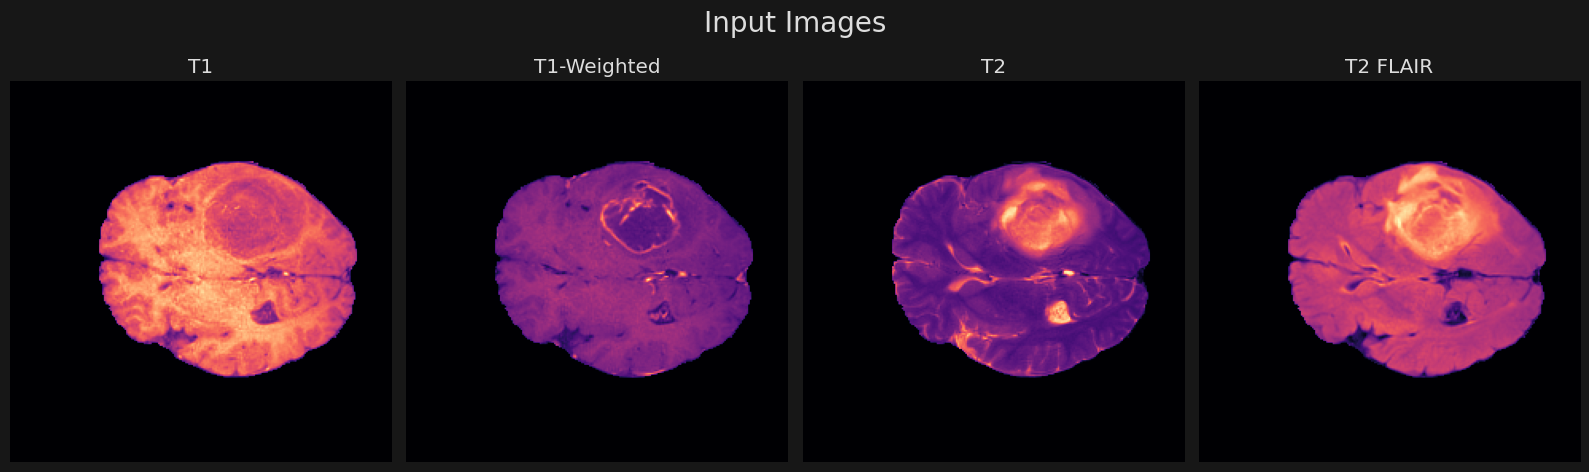

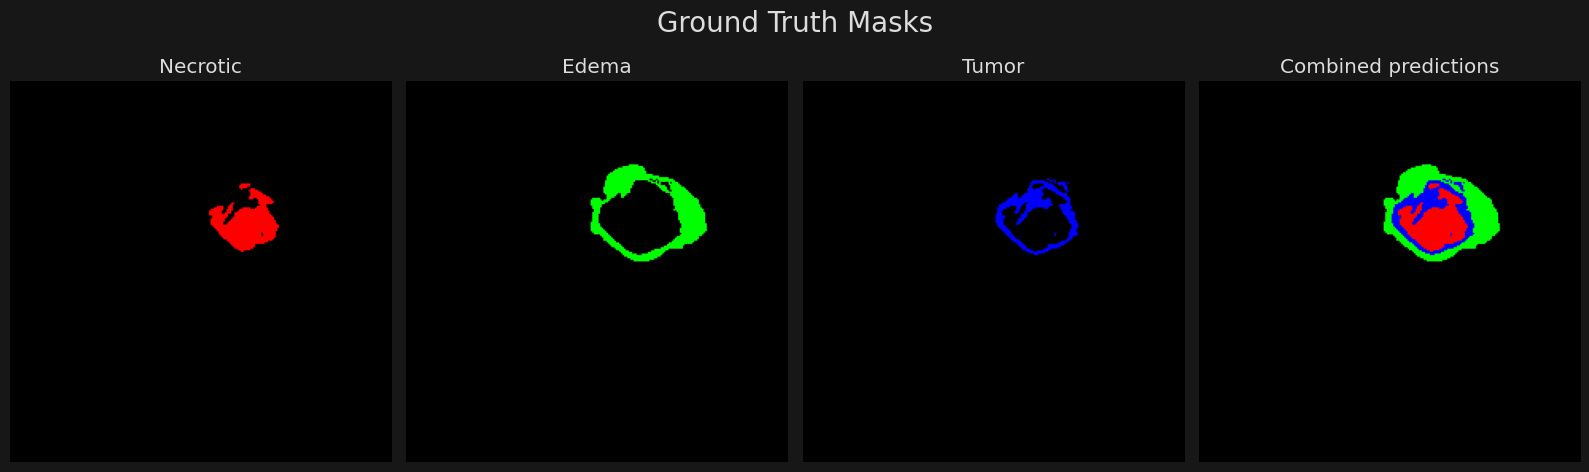

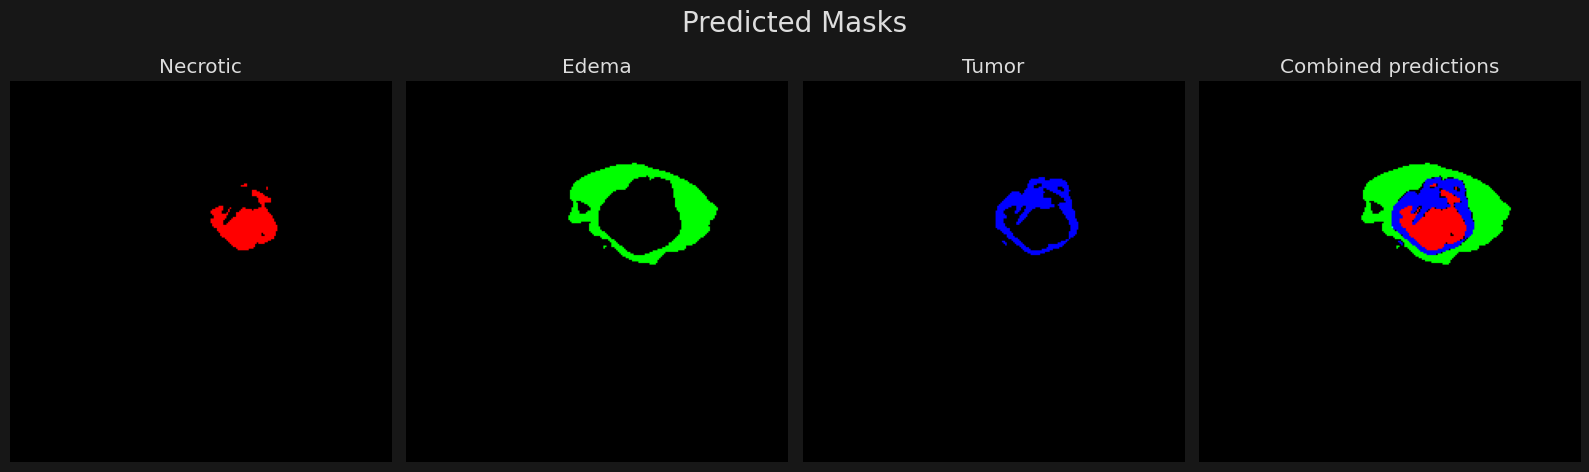

In [10]:
# Predicting random samples from the test set 

random_idx = torch.randint(0, len(test_data), (1,)).item()
sample_input = test_data[random_idx]['Input']
sample_target = test_data[random_idx]['Target']
model.eval()
with torch.inference_mode():
    sample_output = model(sample_input.unsqueeze(dim=0).to(device)).squeeze(dim=0)
sample_output = torch.round(torch.sigmoid(sample_output))

print(f'Data Index : {random_idx}')
plot_inputs(inputs=sample_input)
plot_targets(targets=sample_target, title='Ground Truth Masks')  
plot_targets(targets=sample_output.cpu(), title='Predicted Masks')